In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.4.3)


In [0]:
!rm -r train/healthy/NoAMD

In [0]:
import numpy as np
import torch
import io
import torch.utils.data as utils
import torchvision.models as models
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import torchvision
import torchvision.transforms as transforms
import os
import os
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
import itertools
import scipy
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
#from imblearn.over_sampling import RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler
#from keras.applications.mobilenet import MobileNet
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_curve
#from sklearn.metrics import auc
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [0]:
from google.colab import files
print(files)

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

<module 'google.colab.files' from '/usr/local/lib/python3.6/dist-packages/google/colab/files.py'>


In [99]:

!ls -l
!cp -r val/NoAMD/ val/healthy/



total 56
-rw-r--r-- 1 root root 10774 Nov 17 19:42 accuracy_curve.png
-rw-r--r-- 1 root root  2274 Nov 17 19:42 logs.npy
-rw-r--r-- 1 root root 22316 Nov 17 19:42 loss_curve.png
drwxr-xr-x 2 root root  4096 Nov 15 19:33 sample_data
drwxr-xr-x 7 root root  4096 Nov 17 20:36 test
drwxr-xr-x 7 root root  4096 Nov 17 20:04 train
drwxr-xr-x 7 root root  4096 Nov 17 20:39 val


In [157]:
imageSize=150
train_dir = "train/"
test_dir =  "test/"
# ['DME', 'CNV', 'NORMAL', '.DS_Store', 'DRUSEN']
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['healthy']:
                label = 0
            elif folderName in ['unhealthy']:
                label = 1
 
            
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
X_train, y_train = get_data(train_dir) # Un-comment to use full dataset: Step 1 of 2
X_test, y_test= get_data(test_dir)

from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.2) # Re-comment to use full dataset: Step 2 of 2

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 2)
y_testHot = to_categorical(y_test, num_classes = 2)


100%|██████████| 307/307 [01:10<00:00,  4.38it/s]

100%|██████████| 294/294 [01:06<00:00,  4.36it/s]

100%|██████████| 12/12 [00:05<00:00,  2.27it/s]

100%|██████████| 13/13 [00:05<00:00,  2.30it/s]

100%|██████████| 32/32 [00:07<00:00,  4.45it/s]

100%|██████████| 57/57 [00:18<00:00,  2.59it/s]

100%|██████████| 5/5 [00:01<00:00,  4.51it/s]

100%|██████████| 4/4 [00:00<00:00,  5.60it/s]

100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

100%|██████████| 4/4 [00:01<00:00,  3.72it/s]

100%|██████████| 6/6 [00:01<00:00,  3.27it/s]


In [158]:
print(X_train.shape)
print(X_test.shape)

(715, 150, 150, 3)
(21, 150, 150, 3)


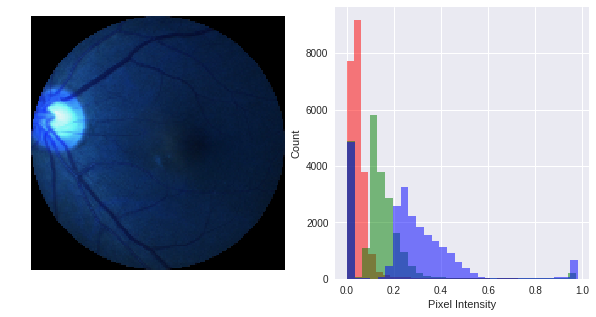

In [159]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

plotHistogram(X_train[1])

In [0]:

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.yticks(range(0.60, 1.00))
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    plt.yticks(range(0.60, 1.00))

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    #plt.yticks(range(0.60, 1.00))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [0]:
from keras.models import load_model
model = load_model('model1.h5')
map_characters1 = {0: 'healthy', 1: 'unhealthy'}
class_weight1 = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
weight_path1 = model.load_weights('model1.h5')
#weight_path2 = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained_model_1 = VGG16(weights = weight_path1, include_top=False, input_shape=(imageSize, imageSize, 3))
#pretrained_model_2 = InceptionV3(weights = None, include_top=False, input_shape=(imageSize, imageSize, 3))
optimizer1 = keras.optimizers.Adam(lr=0.0001)
optimizer2 = keras.optimizers.RMSprop(lr=0.0001)
def pretrainedNetwork(xtrain,ytrain,xtest,ytest,pretrainedmodel,pretrainedweights,classweight,numclasses,numepochs,optimizer,labels):
    base_model = pretrained_model_1 # Topless
    # Add top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(numclasses, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Train top layer
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    # Fit model
    history = model.fit(xtrain,ytrain, epochs=numepochs, class_weight=classweight, validation_data=(xtest,ytest), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    # Evaluate model
    score = model.evaluate(xtest,ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    y_pred = model.predict(xtest)
    print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(ytest,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_learning_curve(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
    plt.show()
    
    model.save('model1.h5')
    
    
    return model
#pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,pretrained_model_1,weight_path1,class_weight1,4,83,optimizer1,map_characters1)

In [0]:
pretrainedNetwork(X_train[:10000], y_trainHot[:10000], X_test[:2000], y_testHot[:2000],pretrained_model_1,weight_path1,class_weight1,2,50,optimizer1,map_characters1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

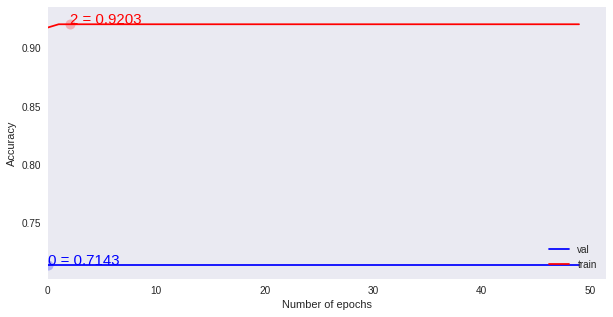

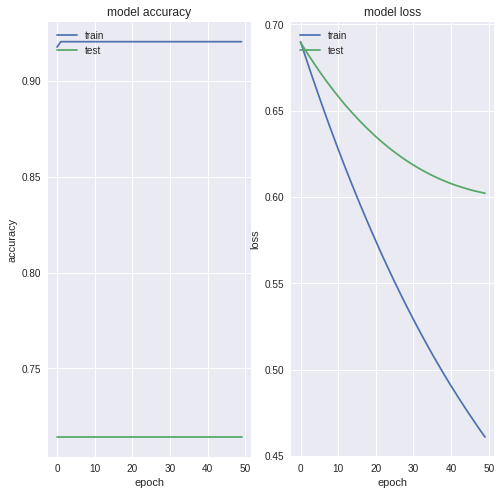

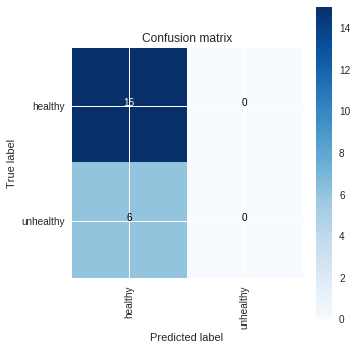

In [163]:
pretrainedNetwork(X_train[:10000], y_trainHot[:10000], X_test[:2000], y_testHot[:2000],pretrained_model_1,weight_path1,class_weight1,2,50,optimizer1,map_characters1)

In [0]:
from keras.models import load_model
final_model = load_model('model1.h5')


In [187]:

zeiss_dir =  "zeiss/"
def get_data_zeiss(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    filename = []
    for image_filename in os.listdir(folder):
        filename.append(image_filename)
        img_file = cv2.imread(folder + '/' + image_filename)
        if img_file is not None:
          img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
          img_arr = np.asarray(img_file)
          pred = final_model.predict(img_arr[np.newaxis,...])
          print(image_filename)
          print(pred)
          X.append(img_arr)
    
#     for i in range(len(filename)):
#       X = np.asarray(X)
#       pred = final_model.predict(X)
#       print("For image ",filename[i], "Prediction",pred)
   
    return X
X_test_final = get_data_zeiss(zeiss_dir) # Un-comment to use full dataset: Step 1 of 2

#print(X_test_final.shape)



# img = cv2.imread('zeiss/Demo_CD_Angiography_(2_visits)_2_19890130_20120320_000019_FAG_OS_1.2.276.0.75.2.3.20.1.3.120320110353953.83527212638_1.jpg')
# pred = final_model.predict(img)
# print(pred)
# Y_pred  = np.argmax(pred,axis = 1) 
# print(Y_pred)
  


Demo_CD_Angiography_(2_visits)_2_19890130_20120320_1059_GREEN_OD_1.2.276.0.75.2.3.20.1.3.120320110047171.83527212638.jpg
[[0.7119066  0.28809333]]
Demo_CD_Angiography_(2_visits)_2_19890130_20120320_000233_FAG_OS_1.2.276.0.75.2.3.20.1.3.120320110608593.83527212638_4.jpg
[[0.71903884 0.28096113]]
Demo_CD_Angiography_(2_visits)_2_19890130_20120320_1059_GREEN_OS_1.2.276.0.75.2.3.20.1.3.120320110128015.83527212638.jpg
[[0.7310488  0.26895124]]
Demo_X_Retina_CSR_Epiretinal_Membrane_19491229_20101012_1157_COLOR_OS_1.2.276.0.75.2.1.20.0.3.101012115902078.35412.20170.jpg
[[0.7789103 0.2210898]]
14_g.jpg
[[0.6837791  0.31622088]]
Demo_CD_Retina_Overview_1_19800428_20100524_000025_FAG_OS_1.2.826.0.1.3680043.2.139.2.1.83527212638.100524113601.68.0_2.jpg
[[0.76142925 0.23857081]]
14_dr.JPG
[[0.6984364 0.3015636]]
Demo_CD_Retina_Overview_1_19800428_20100524_1105_GREEN_OD_1.2.826.0.1.3680043.2.139.2.1.83527212638.100524113108.58.0.jpg
[[0.72844803 0.27155197]]
Demo_CD_Retina_Overview_1_19800428_20100